<a href="https://colab.research.google.com/github/sindoll2/github-project/blob/main/XGBoost_membrane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
myfile = files.upload()

Saving membranedt.csv to membranedt.csv


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree



from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import hstack
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from warnings import simplefilter

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
simplefilter('ignore')

In [ ]:
df = pd.read_csv('membranedt.csv', encoding='cp949')

target_col = 'Membrane Flux \n(LMH)'
seed = 42
print(df.shape)
df.head()

(692, 21)


,Author,Year,Membrane AL Type,Manufacture,Membrane Direction,Flow Orientation\n(counter / cocurrent),Feed Solution (FS),FS Molarity (M),FS Osmotic pressure\n(atm),Draw Solution (DS),...,DS Osmotic pressure\n(atm),P Difference\n(atm),FS Velocity (cm/s),DS Velocity (cm/s),FS Temperature\n(°C),DS Temperature (°C),Membrane Flux \n(LMH),Reverse Salt Flux\n(mol/m2 hr),A\n(LMH/atm),B\n(LMH)
0,Arena et al.,2015,TFC,Oasys,AL-FS,counter,DI,0.0,0.0,NaCl,...,67.11,67.11,25.0,25.0,20.0,20.0,23.84,0.11,0.36,0.07
1,Arena et al.,2015,TFC,Oasys,AL-FS,counter,DI,0.0,0.0,NaCl,...,44.74,44.74,25.0,25.0,20.0,20.0,20.00,0.06,0.45,0.06
2,Arena et al.,2015,TFC,Oasys,AL-FS,counter,DI,0.0,0.0,NaCl,...,22.37,22.37,25.0,25.0,20.0,20.0,14.52,0.04,0.65,0.09
3,Arena et al.,2015,TFC,Oasys,AL-DS,counter,DI,0.0,0.0,NaCl,...,67.11,67.11,25.0,25.0,20.0,20.0,51.74,0.28,0.77,0.19
4,Arena et al.,2015,TFC,Oasys,AL-DS,counter,DI,0.0,0.0,NaCl,...,44.74,44.74,25.0,25.0,20.0,20.0,43.20,0.21,0.97,0.21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Author                                  692 non-null    object 
 1   Year                                    692 non-null    int64  
 2   Membrane AL Type                        692 non-null    object 
 3   Manufacture                             692 non-null    object 
 4   Membrane Direction                      692 non-null    object 
 5   Flow Orientation
(counter / cocurrent)  692 non-null    object 
 6   Feed Solution (FS)                      692 non-null    object 
 7   FS Molarity (M)                         692 non-null    float64
 8   FS Osmotic pressure
(atm)               692 non-null    float64
 9   Draw Solution (DS)                      692 non-null    object 
 10  DS Molarity (M)                         692 non-null    float6

In [ ]:
df['FS Velocity (cm/s)'].fillna(df['FS Velocity (cm/s)'].mean(), inplace=True)
df['DS Velocity (cm/s)'].fillna(df['DS Velocity (cm/s)'].mean(), inplace=True)
df = df.drop(df.columns[[18,20]], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Author                                  692 non-null    object 
 1   Year                                    692 non-null    int64  
 2   Membrane AL Type                        692 non-null    object 
 3   Manufacture                             692 non-null    object 
 4   Membrane Direction                      692 non-null    object 
 5   Flow Orientation
(counter / cocurrent)  692 non-null    object 
 6   Feed Solution (FS)                      692 non-null    object 
 7   FS Molarity (M)                         692 non-null    float64
 8   FS Osmotic pressure
(atm)               692 non-null    float64
 9   Draw Solution (DS)                      692 non-null    object 
 10  DS Molarity (M)                         692 non-null    float6

In [ ]:
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64]and x != target_col] 
cat_cols = ['Author', 'Membrane AL Type', 'Manufacture', 'Membrane Direction','Flow Orientation\n(counter / cocurrent)','Feed Solution (FS)','Draw Solution (DS)']
print(f'    numeric ({len(num_cols)}):\t{num_cols}')
print(f'categorical ({len(cat_cols)}):\t{cat_cols}')

    numeric (11):	['Year', 'FS Molarity (M)', 'FS Osmotic pressure\n(atm)', 'DS Molarity (M)', 'DS Osmotic pressure\n(atm)', 'P Difference\n(atm)', 'FS Velocity (cm/s)', 'DS Velocity (cm/s)', 'FS Temperature\n(°C)', 'DS Temperature (°C)', 'A\n(LMH/atm)']
categorical (7):	['Author', 'Membrane AL Type', 'Manufacture', 'Membrane Direction', 'Flow Orientation\n(counter / cocurrent)', 'Feed Solution (FS)', 'Draw Solution (DS)']


In [ ]:
df[['Year', 'FS Molarity (M)', 'FS Osmotic pressure\n(atm)', 'DS Molarity (M)', 'DS Osmotic pressure\n(atm)', 'P Difference\n(atm)', 'FS Velocity (cm/s)', 'DS Velocity (cm/s)', 'FS Temperature\n(°C)', 'DS Temperature (°C)', 'Membrane Flux \n(LMH)', 'A\n(LMH/atm)']] = df[['Year', 'FS Molarity (M)', 'FS Osmotic pressure\n(atm)', 'DS Molarity (M)', 'DS Osmotic pressure\n(atm)', 'P Difference\n(atm)', 'FS Velocity (cm/s)', 'DS Velocity (cm/s)', 'FS Temperature\n(°C)', 'DS Temperature (°C)', 'Membrane Flux \n(LMH)', 'A\n(LMH/atm)']].apply(np.log1p)
df[num_cols].describe()

,Year,FS Molarity (M),FS Osmotic pressure\n(atm),DS Molarity (M),DS Osmotic pressure\n(atm),P Difference\n(atm),FS Velocity (cm/s),DS Velocity (cm/s),FS Temperature\n(°C),DS Temperature (°C),A\n(LMH/atm)
count,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000
mean,7.608503,0.069615,0.620534,0.761949,3.808628,3.744326,2.395000,2.383771,3.233744,3.248136,0.346776
std,0.001500,0.168848,1.064909,0.424737,0.836119,0.842011,0.943711,0.947628,0.195388,0.192903,0.277207
min,7.604396,0.000000,0.000000,0.048790,1.175573,0.862890,0.350657,0.350657,3.044522,3.043570,0.039221
25%,7.607381,0.000000,0.000000,0.405465,3.157851,3.151453,2.251292,2.251292,3.044522,3.044522,0.139762
50%,7.608871,0.000000,0.000000,0.693147,3.822973,3.773335,2.646175,2.646175,3.258097,3.258097,0.231112
75%,7.609367,0.086178,1.578979,1.098612,4.505129,4.411889,3.109061,3.109061,3.258097,3.258097,0.506818
max,7.610853,0.891998,4.065087,1.871802,5.641588,5.641588,3.931826,3.931826,3.934958,3.934958,1.358409


In [ ]:
features = num_cols + cat_cols

print(df.columns)

Index(['Author', 'Year', 'Membrane AL Type', 'Manufacture',
       'Membrane Direction', 'Flow Orientation\n(counter / cocurrent)',
       'Feed Solution (FS)', 'FS Molarity (M)', 'FS Osmotic pressure\n(atm)',
       'Draw Solution (DS)', 'DS Molarity (M)', 'DS Osmotic pressure\n(atm)',
       'P Difference\n(atm)', 'FS Velocity (cm/s)', 'DS Velocity (cm/s)',
       'FS Temperature\n(°C)', 'DS Temperature (°C)', 'Membrane Flux \n(LMH)',
       'A\n(LMH/atm)'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
X = hstack((df[num_cols],
            ohe.fit_transform(df[cat_cols])))
print(X.shape)

(692, 91)


In [ ]:
from sklearn.preprocessing import StandardScaler

X_trn, X_tst, y_trn, y_tst = train_test_split(X, df[target_col], test_size=0.2, random_state=seed)
clf = XGBRegressor(random_state=seed, n_estimators=1000)
clf.fit(X_trn, np.log1p(y_trn))
p = np.expm1(clf.predict(X_tst))



if('Membrane Flux (LMH)' in df.keys()):
    print(df['Membrane Flux (LMH)'])
else:
    print('Membrane Flux (LMH) not found')

print('r2_score :', r2_score(y_tst, p))
print('MAE :', mean_absolute_error(y_tst, p))
print('MSE :', mean_squared_error(y_tst, p))
print('RMSE : ', mean_squared_error(y_tst, p, squared = False))
print('MAPE :', mean_absolute_percentage_error(y_tst, p))

#print(f"테스트 세트점수 {clf.score(X_tst, y_tst)}")

[08:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Membrane Flux (LMH) not found
r2_score : 0.9821150024679361
MAE : 0.0586072094409323
MSE : 0.00921594612647575
RMSE :  0.0959997194083178
MAPE : 0.025987304071878305


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

KFold = KFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(clf, X, df[target_col], cv=KFold)

print('result :', results)
print('result mean :', results.mean())

[08:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
result : [0.98011733 0.98803831 0.98053891 0.98882157 0.98434961]
result mean : 0.9843731450228829


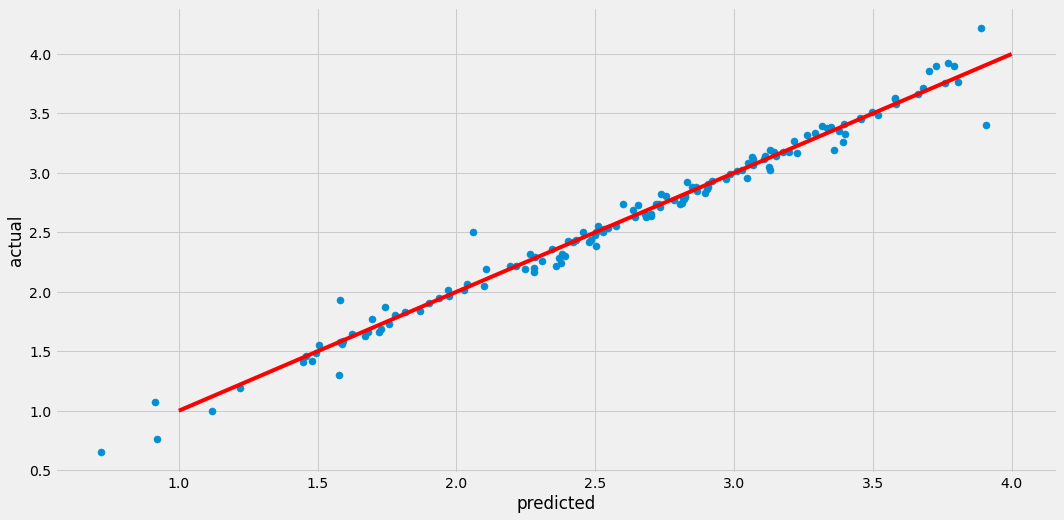

In [ ]:
plt.scatter(p, y_tst, s=50)
plt.xlabel("predicted")
plt.ylabel("actual")
x = np.arange(1,5)
y = x 
plt.plot(x,y, 'r')
plt.show()

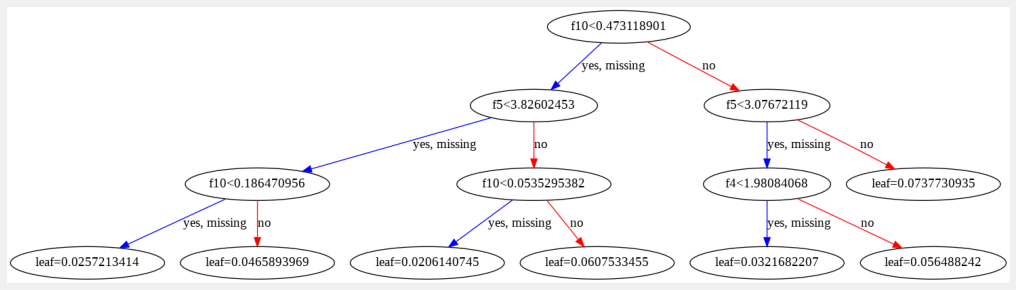

In [ ]:
xgb.plot_tree(clf, num_trees=3)

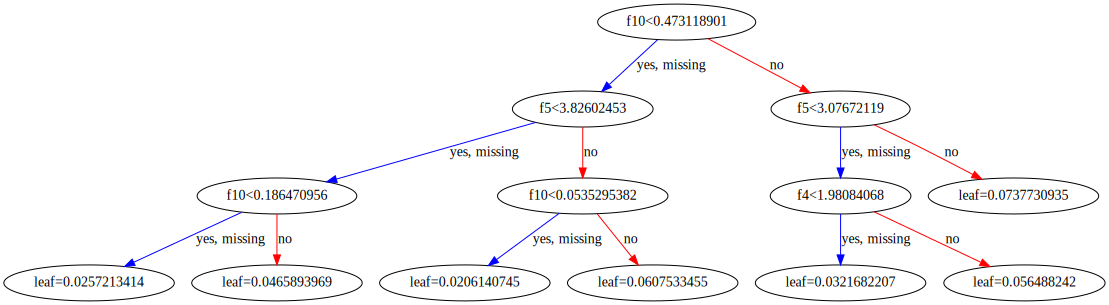

In [ ]:
xgb.to_graphviz(clf, num_trees=3)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

params = { 'min_samples_split':[1,2,3],
          'max_depth' : [1, 2, 3, 4, 5],
          'min_samples_split' : [1, 2,3,4,5],
          'reg_alpha' : np.arange(0, 2, 0.1),
         'reg_lambda' : np.arange(0, 1, 0.1)
          }

gs = GridSearchCV(XGBRegressor(random_state=seed), params, n_jobs=-1)
gs.fit(X_trn, y_trn)

clf = gs.best_estimator_
print(clf.score(X_trn, y_trn))
print(gs.best_params_)
#print(gs.cv_results_['mean_test_score'])

[08:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.998218294136568
{'max_depth': 5, 'min_samples_split': 1, 'reg_alpha': 0.1, 'reg_lambda': 0.9}


accuracy_score는 classification 에서만 사용

In [ ]:
gs_df = pd.DataFrame(gs.cv_results_)
gs_df.loc[:, ['mean_test_score', "params"]]

,mean_test_score,params
0,0.842403,"{'max_depth': 1, 'min_samples_split': 1, 'reg_..."
1,0.842224,"{'max_depth': 1, 'min_samples_split': 1, 'reg_..."
2,0.841819,"{'max_depth': 1, 'min_samples_split': 1, 'reg_..."
3,0.840446,"{'max_depth': 1, 'min_samples_split': 1, 'reg_..."
4,0.839636,"{'max_depth': 1, 'min_samples_split': 1, 'reg_..."
...,...,...
4995,0.950978,"{'max_depth': 5, 'min_samples_split': 5, 'reg_..."
4996,0.952209,"{'max_depth': 5, 'min_samples_split': 5, 'reg_..."
4997,0.951429,"{'max_depth': 5, 'min_samples_split': 5, 'reg_..."
4998,0.953272,"{'max_depth': 5, 'min_samples_split': 5, 'reg_..."


In [ ]:
best_model = gs.best_estimator_
best_model

best_score = gs.best_score_
print('GridSearchCV 최고 정확도 :', best_score)



GridSearchCV 최고 정확도 : 0.9720033981729372


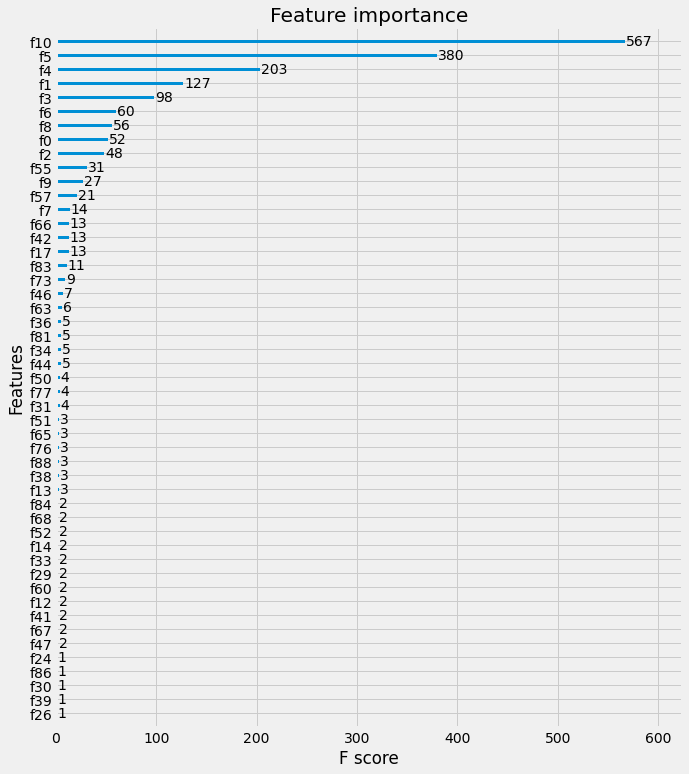

In [ ]:
from xgboost import plot_importance



fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(clf, ax=ax)



In [ ]:
'

'f10'